# Loading and Structuring the chats data

In [417]:
from pathlib import Path
import pandas as pd
import re

In [418]:
def get_structured_chats(chats:list):
    
    chats = ''.join(chats)
    chats = chats.replace("\n\n"," ")
    chats = chats.split('\n')

    pattern_str = r'([0-9]+(/[0-9]+)+)'

    structured_chats = []
    previous_chat = ""
    right_match = True
    hold_chat = False
    count = 0

    # Iterating through every chat message
    for chat_number,chat in enumerate(chats):
        #removes unwanted blank spaces
        chat = re.sub(' +', ' ', chat)
        chat = chat.strip()
        
        # To make split into atleast 2 halfs to handle chat messages without date
        modified_chat = chat + "x:x-x,x"
        date,rest_text = modified_chat.split(",")[:2]
        date = date.strip()

        # To check whether next chat is of valid format containing date
        if chat_number+1 < len(chats): 
            next_modified_chat = chats[chat_number+1] + "x:x-x,x"
            next_date,next_rest_text = next_modified_chat.split(",")[:2]
            next_date = next_date.strip()

            # Hold the current chat message for appending into structured_chats if next chat message is not valid
            if re.match(pattern_str, next_date):
                hold_chat = False
            else:
                hold_chat = True     
        
        # To check whether current message is valid or not
        if not re.match(pattern_str, date) and right_match!=False:
            
            # If not valid store the previous chat message 
            previous_chat = chats[chat_number-1]
            right_match = False
            
        
        # Keep on adding invalid messages to previous message (which is correct)
        if not re.match(pattern_str, date):
            previous_chat = previous_chat + " " +  chat
            
        elif not hold_chat and right_match == False:
            # if no invalid chat message left, then append the previous message (correct) to new_chat
            structured_chats.append(previous_chat)
            previous_chat = ""

        
        # if current chat and next chat is valid
        if not hold_chat and re.match(pattern_str, date):
            right_match = True
            structured_chats.append(chat)

        # if chat number is last and chat messages are not valid
        if (chat_number+1) == len(chats) and right_match==False:
            structured_chats.append(previous_chat)
            

    return structured_chats

In [419]:
def get_notifications_splitted(chats:list):

    notifications = []
    without_notifications = []

    for chat in chats:

        chat_backup = chat

        chat = chat.split(',')[1:]
        chat =  "".join(chat) 
        chat = chat.split('-')[1:]   
        chat = ''.join(chat) 
        
        if ":" not in chat:
            notifications.append(chat_backup)
        else:
            without_notifications.append(chat_backup)
                                                
    return notifications,without_notifications

In [420]:
def get_tablular_chats(chats,table_type:str):

    dates = []
    timestamps = []
    username = []
    message = []
    tabular_chat = None
        
    for chat in chats:
        
        chat_splitted = chat.split(",")
        date,rest_text = chat_splitted[0],chat_splitted[1:]
        rest_text = ','.join(rest_text)
        rest_text = rest_text.strip()
        date = date.strip()
       
        chat_splitted = rest_text.split("-")
        time,rest_text = chat_splitted[0],chat_splitted[1:]
        rest_text = '-'.join(rest_text)
        rest_text = rest_text.strip()
        time = time.strip()


        if table_type == 'without_notifications':

            chat_splitted = rest_text.split(":")
            person,rest_text = chat_splitted[0],chat_splitted[1:]
            rest_text = ':'.join(rest_text)
            rest_text = rest_text.strip()
            person = person.strip()

            dates.append(date)
            timestamps.append(time)
            username.append(person)
            message.append(rest_text)

        elif table_type == 'only_notifications':

            dates.append(date)
            timestamps.append(time)
            message.append(rest_text)

        else:
            print("specify correct table type (without_notifications/only_notifications)")
            return None
    

    if table_type == 'without_notifications':

        tabular_chat = pd.DataFrame({"Date":dates,"time":timestamps,"username":username,"message":message})

    elif table_type == 'only_notifications':
        
        tabular_chat = pd.DataFrame({"Date":dates,"time":timestamps,"notifictions":message})
        
             

    return tabular_chat  
       

In [421]:
def load_chats_table(chatFile:Path):

    with open(chatFile,encoding='utf-8') as textFile:
        chats = textFile.readlines()

        structured_chats = get_structured_chats(chats)
        only_notificatitons,without_notifications = get_notifications_splitted(structured_chats)
        only_notifications_table = get_tablular_chats(only_notificatitons,table_type = 'only_notifications')
        without_notifications_table = get_tablular_chats(without_notifications,table_type = 'without_notifications')

    return only_notifications_table,without_notifications_table

In [422]:
CHAT_FILE = Path('Chats/WhatsApp Chat with 20BCS-38 7th Semester.txt') 

In [423]:
 only_notifications,without_notifications = load_chats_table(CHAT_FILE)

In [424]:
only_notifications.head()

,Date,time,notifictions
0,29/07/23,12:19 pm,Messages and calls are end-to-end encrypted. N...
1,23/07/23,2:06 pm,"Sourabh 7 Mentor created group ""Final year CSE..."
2,29/07/23,12:19 pm,Sourabh 7 Mentor added you
3,29/07/23,12:19 pm,Sourabh 7 Mentor added +91 79799 69265
4,29/07/23,12:35 pm,Sourabh 7 Mentor added +91 98722 29498


In [425]:
without_notifications.head()

,Date,time,username,message
0,29/07/23,12:39 pm,+91 70045 64005,Already Responded Registration Done
1,29/07/23,1:11 pm,+91 83077 89067,Garima 20BCS2031 Registration done! 20BCS9624...
2,29/07/23,3:12 pm,Sourabh 7 Mentor,gaurav 20bcs1316 mohan 20bcs2968 vasu 20bcs793...
3,30/07/23,7:42 pm,+91 6376 881 983,20bcs7936 Vasu Solanki Done
4,31/07/23,9:50 am,"Karan CR Sem5,6",*Most Urgent:* *Accenture Registration :* Stud...


# Feature engineering Date and time columns

In [426]:
def get_24_hrs_format(date:str,time:str):

    meridiem_regx = r'[A-Za-z][A-Za-z]'
    meridiem_match = re.search(meridiem_regx,time)
    meridiem = meridiem_match.group() # extraxt am/pm

    time = time.replace(meridiem,"") # extract hh:mm
    hour,minutes = time.split(':')

    hour = int(hour)
    minutes = int(minutes)

    # converting to 24 hours format

    if hour==12 and meridiem=='am': hour = 0

    if hour>12 and meridiem == 'pm': hour+=12
    
    if hour<10: hour = f"0{hour}"

    if minutes<10:minutes = f"0{minutes}"        


    datetime = f"{date} {hour}:{minutes}"
    
    return datetime

In [427]:
def get_24_hours_datetimes(dates,times) :

    date_times = []

    for date,time in zip(dates,times):

        date_time = get_24_hrs_format(date,time)
        date_times.append(date_time)


    return date_times
    

In [428]:
dates = without_notifications.Date.values
times = without_notifications.time.values

datetime24 = get_24_hours_datetimes(dates,times)
without_notifications.insert(2,"datetime24",datetime24)
without_notifications.datetime24 = pd.to_datetime(without_notifications.datetime24,format='%d/%m/%y %H:%M')
without_notifications.insert(2,"only_date",without_notifications.datetime24.dt.date)

without_notifications = without_notifications.assign(

    hour = without_notifications.datetime24.dt.hour,
    minutes = without_notifications.datetime24.dt.minute,

    Day = without_notifications.datetime24.dt.day,
    Month = without_notifications.datetime24.dt.month,
    Month_name = without_notifications.datetime24.dt.month_name(),
    Year = without_notifications.datetime24.dt.year,

    weekday = without_notifications.datetime24.dt.dayofweek,
    weekday_name = without_notifications.datetime24.dt.day_name(),

)


In [429]:
without_notifications.head()

,Date,time,only_date,datetime24,username,message,hour,minutes,Day,Month,Month_name,Year,weekday,weekday_name
0,29/07/23,12:39 pm,2023-07-29,2023-07-29 12:39:00,+91 70045 64005,Already Responded Registration Done,12,39,29,7,July,2023,5,Saturday
1,29/07/23,1:11 pm,2023-07-29,2023-07-29 01:11:00,+91 83077 89067,Garima 20BCS2031 Registration done! 20BCS9624...,1,11,29,7,July,2023,5,Saturday
2,29/07/23,3:12 pm,2023-07-29,2023-07-29 03:12:00,Sourabh 7 Mentor,gaurav 20bcs1316 mohan 20bcs2968 vasu 20bcs793...,3,12,29,7,July,2023,5,Saturday
3,30/07/23,7:42 pm,2023-07-30,2023-07-30 07:42:00,+91 6376 881 983,20bcs7936 Vasu Solanki Done,7,42,30,7,July,2023,6,Sunday
4,31/07/23,9:50 am,2023-07-31,2023-07-31 09:50:00,"Karan CR Sem5,6",*Most Urgent:* *Accenture Registration :* Stud...,9,50,31,7,July,2023,0,Monday


# Most Active Participants

In [430]:
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import calendar
import numpy as np

In [431]:
def all_years_wise_activity(active_username,chat_details,start_year,end_year):
    
    start_date = datetime(start_year,1,1)
    end_date = datetime(end_year,1,1)

    delta = relativedelta(years=1)

    years = []

    while start_date <= end_date:
        years.append(start_date.year)
        start_date += delta

    user_activity = [0 for count in range(len(years))] 
    username = [active_username for count in range(len(years))] 

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.Year >= start_year) &
                                         (active_user_details.Year <= end_year)]

    activity_details = activity_period.Year.value_counts()

    year_data = activity_details.index
    activity_data = activity_details.values

    for year,activity in zip(year_data,activity_data):
        index = years.index(year)
        user_activity[index] = activity

    
    return username,years,user_activity

In [432]:
def all_months_wise_activity(active_username,chat_details,year,start_month,end_month):
    

    start_date = datetime(year,start_month,1)
    end_date = datetime(year,end_month,1)

    delta = relativedelta(months=1)

    months = []
    
    while start_date <= end_date:
        months.append(start_date.month)
        start_date += delta

    user_activity = [0 for count in range(len(months))] 
    username = [active_username for count in range(len(months))]

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.Month >= start_month) & 
                                        (active_user_details.Month <= end_month)]
    
    activity_details = activity_period.Month.value_counts()

    month_data = activity_details.index
    activity_data = activity_details.values

    for month,activity in zip(month_data,activity_data):

        index = months.index(month)
        user_activity[index] = activity

    #provide month number
    month_names = []

    for month_number in months:
        datetime_object = datetime.strptime(str(month_number), "%m")
        full_month_name = datetime_object.strftime("%B")
        month_names.append(full_month_name)


    return username,month_names,user_activity


In [433]:
def all_days_wise_activity(active_username,chat_details,start_year,start_month,start_day,end_year,end_month,end_day):

    start_date = date(start_year,start_month,start_day)
    end_date = date(end_year,end_month,end_day)

    delta = relativedelta(days=1)

    dates = []

    current_date = start_date

    while current_date <= end_date:
        dates.append(current_date)
        current_date += delta

    user_activity = [0 for count in range(len(dates))] 
    username = [active_username for count in range(len(dates))]

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.only_date >= start_date) & 
                                        (active_user_details.only_date <= end_date)]

    activity_details =  activity_period.only_date.value_counts()

    dates_data = activity_details.index
    activity_data = activity_details.values

    for date_data,activity in zip(dates_data,activity_data):

        index = dates.index(date_data)
        user_activity[index] = activity
        
         
    return username,dates,user_activity      



In [494]:
def all_weekday_wise_activity(username,chat_details,year,month):
    _,_,w1_user_activity = all_days_wise_activity(username,chat_details,year,month,1,year,month,7)
    _,_,w2_user_activity = all_days_wise_activity(username,chat_details,year,month,8,year,month,14)
    _,_,w3_user_activity = all_days_wise_activity(username,chat_details,year,month,15,year,month,21)
    username,weekdates,w4_user_activity = all_days_wise_activity(username,chat_details,year,month,22,year,month,28)

    weekdays_names = []

    for date in weekdates:
        day_name = calendar.day_name[date.weekday()]
        weekdays_names.append(day_name)


    return  username,weekdays_names,\
            [w1_user_activity,w2_user_activity,w3_user_activity,w4_user_activity]    


In [464]:
def all_hours_wise_activity(active_username,chat_details,year,month,start_day,end_day,start_hour,end_hour):
    
    start_dateHours = datetime(year,month,start_day,start_hour,0,0)
    end_dateHours = datetime(year, month,end_day,end_hour,0,0)

    delta = timedelta(hours=1)

    dateHours = []
    dateHours_data = []
    current_dateHours = start_dateHours

    while current_dateHours <= end_dateHours:

        dateHours.append(current_dateHours)
        current_dateHours += delta

    username = [active_username for count in range(len(dateHours))] 

    active_user_details = chat_details[chat_details.username == active_username]
    
    start = range(len(dateHours)-1)
    end = range(1,len(dateHours))
    
    for start_idx,end_idx in zip(start,end):
        
        start_Hour = dateHours[start_idx]
        end_Hour = dateHours[end_idx]

        activity_period = active_user_details[(active_user_details.datetime24>=start_Hour)&
                                    (active_user_details.datetime24<=end_Hour)]

        dateHours_data.append(activity_period.shape[0])

    return username[:-1],dateHours[:-1],dateHours_data

In [491]:
def all_minutes_wise_activity(active_username,chat_details,year,month,day,start_hour,start_minutes,end_hour,end_minutes):
    
    start_dateHoursMinutes = datetime(year,month,day,start_hour,start_minutes,0)
    end_dateHoursMinutes = datetime(year, month,day,end_hour,end_minutes,0)

    delta = timedelta(minutes=1)

    dateHoursMinutes = []
    dateHoursMinutes_data = []

    current_dateHoursMinutes = start_dateHoursMinutes

    while current_dateHoursMinutes <= end_dateHoursMinutes:
        dateHoursMinutes.append(current_dateHoursMinutes)
        current_dateHoursMinutes += delta

    username = [active_username for count in range(len(dateHoursMinutes))] 

    active_user_details = chat_details[chat_details.username == active_username]
    
    start = range(len(dateHoursMinutes)-1)
    end = range(1,len(dateHoursMinutes))
    
    for start_idx,end_idx in zip(start,end):
        
        start_Minute = dateHoursMinutes[start_idx]
        end_Minute = dateHoursMinutes[end_idx]

        activity_period = active_user_details[(active_user_details.datetime24>=start_Minute)&
                                    (active_user_details.datetime24<=end_Minute)]

        dateHoursMinutes_data.append(activity_period.shape[0])


    return username[:-1],dateHoursMinutes[:-1],dateHoursMinutes_data


In [495]:
top_active_users = 7
active_participation_count = without_notifications.username.value_counts()[:top_active_users]
active_users = active_participation_count.index

In [496]:
others_df = without_notifications.copy()
active_users_dfs = []

for user in active_users:
    active_users_df = without_notifications[without_notifications.username == user]
    active_users_dfs.append(active_users_df)


for user in active_users:
    others_df = others_df[others_df.username != user]

others_df.username = "others"
active_users_dfs.append(others_df)

chat_details = pd.concat(active_users_dfs)  
active_users = active_users.insert(top_active_users,"others")  


In [497]:
timeline_plot_names = ["Years","Months","Weekdays","Days","Hours","Minutes"]

users_timeline_plotting_details = {}

for user in active_users:

    users_timeline_plotting_details[user] = {}

    for timeline_name in timeline_plot_names:

        if timeline_name == "Weekdays":
            users_timeline_plotting_details[user].update({timeline_name:{
                                            "username":"","x":"",
                                            "y1":"","y2":"","y3":"","y4":""}})

            continue

        users_timeline_plotting_details[user].update({timeline_name:{"username":"","x":"","y":""}})


In [501]:
for username in active_users:

    year_wise_username,years,per_year_user_activity = all_years_wise_activity(username,chat_details,
                                                                    start_year = 2020,end_year=2025)
    month_wise_username,months,per_month_user_activity = all_months_wise_activity(username,chat_details,
                                                                    year=2023,start_month=7,end_month=11)
    weekday_wise_username,weeks,per_week_user_activity = all_weekday_wise_activity(username,chat_details,
                                                                    year=2023,month=10)
    day_wise_username,days,per_day_user_activity = all_days_wise_activity(username,chat_details,
                            start_year=2023,start_month=8,start_day=1,end_year =2023,end_month=8,end_day=30)
    hour_wise_username,hours,per_hour_user_activity = all_hours_wise_activity(username,chat_details,
                            year=2023,month=8,start_day=3,end_day=3,start_hour=10,end_hour=20)
    minute_wise_username,minutes,per_minute_user_activity = all_minutes_wise_activity(username,chat_details,    
                            year=2023,month=8,day=3,start_hour = 10,end_hour=11,start_minutes=0,end_minutes=50)
    
   
    users_timeline_plotting_details[username]["Years"]["username"] = year_wise_username
    users_timeline_plotting_details[username]["Years"]["x"] = years
    users_timeline_plotting_details[username]["Years"]["y"] = per_year_user_activity

    users_timeline_plotting_details[username]["Months"]["username"] = month_wise_username
    users_timeline_plotting_details[username]["Months"]["x"] = months
    users_timeline_plotting_details[username]["Months"]["y"] = per_month_user_activity

    users_timeline_plotting_details[username]["Days"]["username"] = day_wise_username
    users_timeline_plotting_details[username]["Days"]["x"] = days
    users_timeline_plotting_details[username]["Days"]["y"] = per_day_user_activity

    users_timeline_plotting_details[username]["Weekdays"]["username"] = weekday_wise_username
    users_timeline_plotting_details[username]["Weekdays"]["x"] = weeks
    users_timeline_plotting_details[username]["Weekdays"]["y1"] = per_week_user_activity[0]
    users_timeline_plotting_details[username]["Weekdays"]["y2"] = per_week_user_activity[1]
    users_timeline_plotting_details[username]["Weekdays"]["y3"] = per_week_user_activity[2]
    users_timeline_plotting_details[username]["Weekdays"]["y4"] = per_week_user_activity[3]

    users_timeline_plotting_details[username]["Hours"]["username"] = hour_wise_username
    users_timeline_plotting_details[username]["Hours"]["x"] = hours
    users_timeline_plotting_details[username]["Hours"]["y"] = per_hour_user_activity

    users_timeline_plotting_details[username]["Minutes"]["username"] = minute_wise_username
    users_timeline_plotting_details[username]["Minutes"]["x"] = minutes
    users_timeline_plotting_details[username]["Minutes"]["y"] = per_minute_user_activity
    

In [508]:
timeline_plot_names = ["Years","Months","Weekdays","Days","Hours","Minutes"]

timeline_type_dataframe = {timeline : "" for timeline in timeline_plot_names }

for timeline in timeline_plot_names:

    df_timeline_list = []

    for user in active_users:
        df = pd.DataFrame(users_timeline_plotting_details[user][timeline])
        df_timeline_list.append(df)

    timeline_df = pd.concat(df_timeline_list,ignore_index=True)
    timeline_type_dataframe[timeline] =  timeline_df   


In [509]:
import plotly.express as px

figures = {}

for timeline_type in timeline_type_dataframe.keys():

    timeline_df = timeline_type_dataframe[timeline_type]


    if timeline_type == "Weekdays":

        weeks_plot = []

        for week_num in range(1,5):

            fig = px.line(timeline_df, x="x", y=f"y{week_num}", 
                        labels={
                                "x": timeline_type,
                                f"y{week_num}": "Message count",
                                "username": "Users"
                            },

                        title=f"{timeline_type} [week - {week_num}] timeline", 
                        color='username',markers = True
                        
                        )
    
            weeks_plot.append(fig)
            fig.show()

        figures[timeline_type] = weeks_plot
             
        continue          



    fig = px.line(timeline_df, x="x", y="y", 
                labels={
                        "x": timeline_type,
                        "y": "Message count",
                        "username": "Users"
                    },

                title=f"{timeline_type} timeline", 
                color='username',markers = True
                
                )


    if timeline_type == "Years":
        fig.update_layout( xaxis={
            'range': [timeline_df['x'].min(), timeline_df['x'].max()], 
            'tickvals': [*range(int(timeline_df['x'].min()), int(timeline_df['x'].max()))]})

    if timeline_type in ["Years","Days","Hours","Minutes"]:
        fig.update_xaxes(rangeslider_visible=True)            

    figures[timeline_type] = fig

    fig.show()



# Bargraph - counting No. of messages in a given timeline

In [505]:
bar_plot_names = ["Years","Months","Weekdays","Days","Hours","Minutes"]
bar_type_dataframe = {bar_plot_type : "" for bar_plot_type in bar_plot_names }

In [506]:
for timeline_type,timeline_df in timeline_type_dataframe.items():
    df = timeline_df.groupby("x").sum()
    df.drop("username",inplace=True,axis=1)
    df.reset_index(inplace=True)
    bar_type_dataframe[timeline_type]=df

In [507]:
import plotly.express as px

bar_figures = {}

for barplot_type in bar_type_dataframe.keys():

    barplot_df = bar_type_dataframe[barplot_type]


    if barplot_type == "Weekdays":

        weeks_plot = []

        for week_num in range(1,5):

            fig = px.bar(barplot_df, x="x", y=f"y{week_num}", text_auto='.2s',
                        labels={
                                "x": barplot_type,
                                f"y{week_num}": "Message count",
                                 },

                        title=f"{barplot_type} [week - {week_num}] timeline", 
                      
                        )
    
            weeks_plot.append(fig)
            fig.show()

        bar_figures[barplot_type] = weeks_plot
             
        continue          



    fig = px.bar(barplot_df, x="x", y="y", text_auto='.2s',
                labels={
                        "x": barplot_type,
                        "y": "Message count",
                        "username": "Users"
                    },

                title=f"{barplot_type} timeline", 
                            
                )

    if barplot_type == "Years":
        fig.update_layout( xaxis={
            'range': [barplot_df['x'].min(), barplot_df['x'].max()], 
            'tickvals': [*range(int(barplot_df['x'].min()), int(barplot_df['x'].max()))]})         

    if barplot_type in ["Years","Days","Hours","Minutes"]:
        fig.update_xaxes(rangeslider_visible=True)            

    bar_figures[barplot_type] = fig

    fig.show()



In [184]:
stopwords = open('stop_hinglish.txt').read()   
stopwords = stopwords.split('\n')

In [203]:
import string
import re
 
def clean_message(message):

    message = message.strip()
    lower_case = message.lower()
    translation_table = str.maketrans('', '', string.punctuation+'0123456789\t')
    without_punctuations = lower_case.translate(translation_table)
    removed_extra_blank_spaces = re.sub(' +', ' ',without_punctuations)

    with_stopwords = removed_extra_blank_spaces.split(" ")

    without_stopwords = []

    for word in with_stopwords:
        if word not in stopwords:
            without_stopwords.append(word)

    cleaned_message = ' '.join(without_stopwords)
    
    return cleaned_message

In [370]:
from collections import Counter 

def get_most_frequent_word(message,word_frequency_threshold = 3,word_length_threshold = 1):
    
    words_list = message.split(" ")
    proper_length_word_list = [word for word in words_list if len(word)>word_length_threshold]

    words_duplicates_count_dict = Counter(proper_length_word_list) 
    desc_order = sorted(words_duplicates_count_dict.items(), key=lambda x:x[1],reverse=True)

    if len(desc_order)==0:
        return "No specific discussion"
        
    highest_word_and_frequency = desc_order[0]
    word,_ = highest_word_and_frequency
       
    if words_duplicates_count_dict[word]>=word_frequency_threshold:
        return word

    return  "No specific discussion"       

In [357]:
def year_wise_most_frequent_word(chat_details,start_year,end_year):
    
    start_date = datetime(start_year,1,1)
    end_date = datetime(end_year,1,1)

    delta = relativedelta(years=1)

    years = []
    most_frequent_words = []

    while start_date <= end_date:
        years.append(start_date.year)
        start_date += delta

    user_activity = ["no specific discussion" for count in range(len(years))] 
   
    for year in years:
        activity_year = chat_details[chat_details.Year == year]
        message = ' '.join(list(activity_year.message.values))
        cleaned_message = clean_message(message)
        most_frequent_word = get_most_frequent_word(cleaned_message,word_frequency_threshold = 1,word_length_threshold = 2)
        most_frequent_words.append(most_frequent_word)

            
    return years,most_frequent_words

In [371]:
def months_wise_most_frequent_word(chat_details,year,start_month,end_month):
    
    start_date = datetime(year,start_month,1)
    end_date = datetime(year,end_month,1)

    delta = relativedelta(months=1)

    months = []
    most_frequent_words = []
    
    while start_date <= end_date:
        months.append(start_date.month)
        start_date += delta

    user_activity = ["no specific discussion" for count in range(len(months))] 
    


    for month in months:
        activity_month = chat_details[chat_details.Month == month]
        message = ' '.join(list(activity_month.message.values))
        cleaned_message = clean_message(message)
        most_frequent_word = get_most_frequent_word(cleaned_message,word_frequency_threshold = 1,word_length_threshold = 2)
        most_frequent_words.append(most_frequent_word)
        
    
    #provide month number
    month_names = []
    
    for month_number in months:
        datetime_object = datetime.strptime(str(month_number), "%m")
        full_month_name = datetime_object.strftime("%B")
        month_names.append(full_month_name)


    return month_names,most_frequent_words


In [385]:
def days_wise_most_frequent_word(chat_details,start_year,start_month,start_day,end_year,end_month,end_day):

    start_date = date(start_year,start_month,start_day)
    end_date = date(end_year,end_month,end_day)

    delta = relativedelta(days=1)

    dates = []
    most_frequent_words = []

    current_date = start_date

    while current_date <= end_date:
        dates.append(current_date)
        current_date += delta

    user_activity = ["no specific discussion" for count in range(len(dates))] 
    
    for current_date in dates:
        activity_day = chat_details[chat_details.only_date == current_date]
        message = ' '.join(list(activity_day.message.values))
        cleaned_message = clean_message(message)
        most_frequent_word = get_most_frequent_word(cleaned_message,word_frequency_threshold = 5,word_length_threshold = 2)
        most_frequent_words.append(most_frequent_word)

           
         
    return dates,most_frequent_words      



In [392]:
def weekday_wise_most_frequent_word(chat_details,year,month):
    _,w1_most_frequent_words = days_wise_most_frequent_word(chat_details,year,month,1,year,month,7)
    _,w2_most_frequent_words = days_wise_most_frequent_word(chat_details,year,month,8,year,month,14)
    _,w3_most_frequent_words = days_wise_most_frequent_word(chat_details,year,month,15,year,month,21)
    weekdates,w4_most_frequent_words = days_wise_most_frequent_word(chat_details,year,month,22,year,month,28)

    weekdays_names = []

    for date in weekdates:
        day_name = calendar.day_name[date.weekday()]
        weekdays_names.append(day_name)


    return  weekdays_names,\
            [w1_most_frequent_words,w2_most_frequent_words,w3_most_frequent_words,w4_most_frequent_words]    


In [513]:
def hours_wise_most_frequent_word(chat_details,year,month,start_day,end_day,start_hour,end_hour):
    
    start_dateHours = datetime(year,month,start_day,start_hour,0,0)
    end_dateHours = datetime(year, month,end_day,end_hour,0,0)

    delta = timedelta(hours=1)

    dateHours = []
    most_frequent_words = []

    current_dateHours = start_dateHours

    while current_dateHours <= end_dateHours:
        dateHours.append(current_dateHours)
        current_dateHours += delta

    user_activity = ["no specific discussion" for count in range(len(dateHours))] 
    
    start = range(len(dateHours)-1)
    end = range(1,len(dateHours))
    
    for start_idx,end_idx in zip(start,end):
        
        start_Hour = dateHours[start_idx]
        end_Hour = dateHours[end_idx]

        activity_Hour = chat_details[(chat_details.datetime24>=start_Hour)&
                                    (chat_details.datetime24<=end_Hour)]

        message = ' '.join(list(activity_Hour.message.values))
        cleaned_message = clean_message(message)
        most_frequent_word = get_most_frequent_word(cleaned_message,word_frequency_threshold = 1,word_length_threshold = 2)
        most_frequent_words.append(most_frequent_word)                                    
     

    return dateHours[:-1],most_frequent_words

In [514]:
def minutes_wise_most_frequent_word(chat_details,year,month,day,start_hour,start_minutes,end_hour,end_minutes):
    
    start_dateHoursMinutes = datetime(year,month,day,start_hour,start_minutes,0)
    end_dateHoursMinutes = datetime(year, month,day,end_hour,end_minutes,0)

    delta = timedelta(minutes=1)

    dateHoursMinutes = []
    most_frequent_words = []

    current_dateHoursMinutes = start_dateHoursMinutes

    while current_dateHoursMinutes <= end_dateHoursMinutes:
        dateHoursMinutes.append(current_dateHoursMinutes)
        current_dateHoursMinutes += delta

    user_activity = ["no specific discussion" for count in range(len(dateHoursMinutes))] 
    
    start = range(len(dateHoursMinutes)-1)
    end = range(1,len(dateHoursMinutes))

    for start_idx,end_idx in zip(start,end):
        
        start_Minute = dateHoursMinutes[start_idx]
        end_Minute = dateHoursMinutes[end_idx]

        activity_Minute = chat_details[(chat_details.datetime24>=start_Minute)&
                                    (chat_details.datetime24<=end_Minute)]

        message = ' '.join(list(activity_Minute.message.values))
        cleaned_message = clean_message(message)
        most_frequent_word = get_most_frequent_word(cleaned_message,word_frequency_threshold = 1,word_length_threshold = 1)
        most_frequent_words.append(most_frequent_word)   

        print(len(dateHoursMinutes),len(most_frequent_words))

    return dateHoursMinutes[:-1],most_frequent_words


In [515]:
chat_details = without_notifications.copy()

# year_wise_most_frequent_word(chat_details,2020,2025)
# months_wise_most_frequent_word(chat_details,2023,8,10)
# days_wise_most_frequent_word(chat_details,2023,8,3,2023,8,25)
# weekday_wise_most_frequent_word(chat_details,2023,8)
# hours_wise_most_frequent_word(chat_details,2023,8,22,22,10,15)
# minutes_wise_most_frequent_word(chat_details,2023,8,22,10,0,15,50)

In [92]:
# # I largely keep the codes and comments the same as the original answer, with the modification highlighted under '#######'
# import plotly.express as px
# import plotly.subplots as sp

# # Create figures in Express

# traces = []

# for idx,figure in enumerate(figures):

#     figure_trace = []

#     for trace in range(len(figure["data"])):

#         # if idx==0:
#         #     figure["data"][trace]['showlegend'] = False

#         figure_trace.append(figure["data"][trace])
#         # figure["data"][trace]['showlegend'] = False 

#     traces.append(figure_trace)    



   
# # Create a 1x2 subplot
# this_figure = sp.make_subplots(rows = 1, cols = len(traces), subplot_titles = ['', 'Line'])
# this_figure.update_layout(height = 500, width = 2500, title_text = "User timelines", title_font_size = 25)

# # Get the Express fig broken down as traces and add the traces to the proper plot within the subplot

# for idx,figure_traces in enumerate(traces):

#     for trace in figure_traces:
#         this_figure.append_trace(trace, row = 1, col = idx+1)


    
# this_figure.show()

# Converting raw data into Data frame

In [ ]:
# for particular user
df = WCA[WCA["username"]=='Aditya Thakur Cu']
hourly = df.pivot_table(index='Day name', columns='periods', values='chats', aggfunc='count').fillna(0)
hourly

periods,00-01,10-11,11-12,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00,9-10
Day name,,,,,,,,,,,,,,,
Friday,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Monday,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Saturday,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0
Thursday,0.0,0.0,0.0,4.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuesday,1.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,14.0,2.0
Wednesday,7.0,0.0,11.0,0.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: xlabel='periods', ylabel='Day name'>

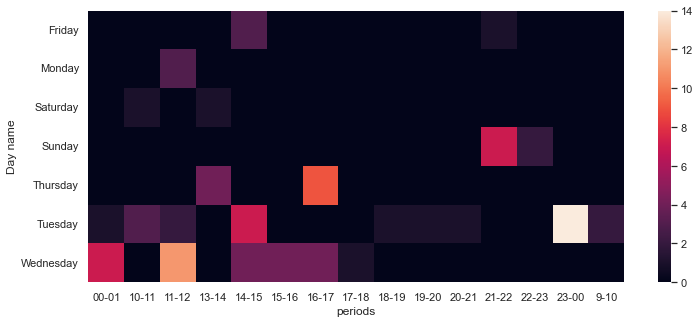

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(hourly)

In [ ]:
WCA["only_date"]=WCA["date_time"].dt.date
WCA.tail()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes,only_date,Day name,periods
1533,9/18/22,1:31,Rahul Sem 6,https://youtu.be/eo5bmse-Chs,2022-09-18 01:31:00,2022,September,9,18,1,31,2022-09-18,Sunday,01-02
1534,9/18/22,1:42,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU,2022-09-18 01:42:00,2022,September,9,18,1,42,2022-09-18,Sunday,01-02
1535,9/18/22,2:03,+91 79090 27850,"69 signatures are still needed, can you add yo...",2022-09-18 02:03:00,2022,September,9,18,2,3,2022-09-18,Sunday,02-03
1536,9/18/22,7:45,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...,2022-09-18 07:45:00,2022,September,9,18,7,45,2022-09-18,Sunday,07-08
1537,9/18/22,7:59,+91 97791 17726,https://www.google.com/amp/s/m.jagran.com/lite...,2022-09-18 07:59:00,2022,September,9,18,7,59,2022-09-18,Sunday,07-08


# Similar users

In [ ]:
WCA_copy.drop(["date","time"],inplace=True,axis=1)
WCA_copy

,username,chats
0,+91 6395 347 424,<Media omitted>
1,+91 6395 347 424,<Media omitted>
2,+91 6395 347 424,<Media omitted>
3,+91 6395 347 424,<Media omitted>
4,+91 6395 347 424,<Media omitted>
...,...,...
1533,Rahul Sem 6,https://youtu.be/eo5bmse-Chs
1534,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU
1535,+91 79090 27850,"69 signatures are still needed, can you add yo..."
1536,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...


In [ ]:
emojis=[]

e=[]

for i,j in emoji.get_emoji_unicode_dict('en').items():
    e.append(j)

e.append('✌')
e.append('✍️')
e.append('☝️')

new_chats=[] 

for msg in WCA_copy["chats"]:
    for words in msg:
        for letters in words:
            if(letters in e):
                msg = msg.replace(letters,"")
    
    new_chats.append(msg)

WCA_copy["chats"]=new_chats 


In [ ]:
from urlextract import URLExtract
extract = URLExtract()

new_chats=[]
for msg in WCA_copy["chats"]:
    for links in extract.find_urls(msg):
        msg=msg.replace(links,'')
    
    new_chats.append(msg)
    
WCA_copy["chats"]=new_chats
WCA_copy=WCA_copy[WCA_copy["chats"]!='<Media omitted> ']

In [ ]:
WCA_copy.drop("index",axis=1,inplace=True)

In [ ]:
WCA_copy=WCA_copy[WCA_copy["chats"]!=' ']

In [ ]:
WCA_copy.reset_index(inplace=True)

In [ ]:
WCA_copy.drop("index",axis=1,inplace=True)

In [ ]:
WCA_copy

,username,chats
0,Gourav,Someone please share the mooc form
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,Gourav,Thank
3,Gourav,Thank
4,+91 70090 64835,Chill buddy
...,...,...
1007,+91 94226 69124,Full support
1008,+91 79090 27850,"Hello guys, A girl attempted suicide in Cu tod..."
1009,+91 79090 27850,++infinity
1010,+91 70823 30760,Full support


In [ ]:
WCA_copy=WCA_copy.drop_duplicates(keep="first").reset_index().drop("index",axis=1)
WCA_copy 

,username,chats
0,Gourav,Someone please share the mooc form
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,Gourav,Thank
3,+91 70090 64835,Chill buddy
4,Aditya Thakur Cu,@919422669124
...,...,...
930,+91 94226 69124,Full support
931,+91 79090 27850,"Hello guys, A girl attempted suicide in Cu tod..."
932,+91 79090 27850,++infinity
933,+91 70823 30760,Full support


In [ ]:
user_dict={}

for user in WCA_copy["username"].unique().tolist():
    user_WCA = WCA_copy[WCA_copy["username"]==user]
    
    user_chats=[]
    for msg in user_WCA["chats"]:
        user_chats.append(msg)
    
    user_chats=' '.join(user_chats)
    user_dict[user]=user_chats

In [ ]:
user_dict

{'Gourav': 'Someone please share the mooc form  Thank   Domain?  You deleted this message  White sheet  Anyone good at node js ',
 'Aditya Thakur Cu': 'Regarding MOOCS-III   Pls do not try and upload ur proofs on the Drive.... pls kindly upload the proofs in the pdf format under the name (UID_NAME)  in the form link...    Link of Form (for proof) :   @919422669124  As per instructions received, a workshop is scheduled in the auditorium of Block-C2 on 9th August, 2022  and for that around 500 students are required from CSE-3rd Year.   Note: It is mandatory for students to bring their laptops during the workshop.   Kindly find the details of the TPP sections(BE CSE/IT 2020 Batch) which are required for a workshop on 9th August, 2022 and they are required to report in the auditorium at 10:25 am sharp.   1. 20BCS_MM-804 2. 20BCS_MM-805 3. 20BCS_MM-806 4. 20BCS_MM-807 5. 20BCS_MM-901 6. 20BCS_MM-902 7. 20BCS_MM-903   @DeepShikha Chhabra  Kindly ensure faculty having lectures in the said dur

In [ ]:
user=[]
chats=[]

for k,v in user_dict.items():
    user.append(k)
    chats.append(v)
    
new_WCA=pd.DataFrame({'user':user,'chats':chats})    

In [ ]:
new_WCA

,user,chats
0,Gourav,Someone please share the mooc form Thank Do...
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,+91 70090 64835,Chill buddy Cr ne bheja Kya mtlb h Impressi...
3,+91 70823 30760,Congrats Nikhil Congrats karan Grp mein hai ...
4,+91 6392 315 634,Karan bhai apna cr Hn hai @919422669124 Pic...
5,Rahul Sem 6,congratulations karan bhai anyone want to joi...
6,+91 94226 69124,Thanx boiz Han bhai hu sahi h ye bna sakte...
7,+91 99921 99871,*FOR CRYPTO TRADERS* *Daily Earn Profite* ...
8,+91 79090 27850,haan Jaan hi lelo hamaari .... Haan Yahi du...
9,+91 86072 73793,Chal kya rha vha Kitne meeting chalri? Kisi ...


In [ ]:
words=[]


for i in range(new_WCA.shape[0]):    
        test_str = new_WCA["chats"][i]
        trans_table = test_str.maketrans('','',"""0123456789!"#$%&'()*+,-_–./·:;<=>?@[\]^_`{|}~""")
        test_str = test_str.translate(trans_table)

        for wrd in test_str.lower().split(" "):
            if wrd not in hinglish_stopwords and  wrd not in english_stopwords:
                words.append(wrd)
        
        new_WCA["chats"][i]=' '.join(words)
        words=[]

In [ ]:
new_WCA=new_WCA[new_WCA["chats"]!='']
new_WCA.reset_index(inplace=True)
new_WCA.drop("index",axis=1,inplace=True)
new_WCA

,user,chats
0,Gourav,share mooc form domain deleted message white s...
1,Aditya Thakur Cu,moocsiii pls upload proofs drive pls kindly up...
2,+91 70090 64835,chill buddy bheja mtlb impressive buddij daa e...
3,+91 70823 30760,congrats nikhil congrats karan grp voh ptaa im...
4,+91 6392 315 634,karan hn piche baitha workshops block row hn d...
5,Rahul Sem 6,congratulations karan join project group membe...
6,+91 94226 69124,boiz bna meeting join meeting join karlo abi s...
7,+91 99921 99871,crypto traders daily earn profite helping trad...
8,+91 79090 27850,jaan lelo hamaari due list subject ohk ml set ...
9,+91 86072 73793,vha meeting chalri quiz show hora lms soft ski...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features = 200) 

In [ ]:
WCA_vectors=count_vect.fit_transform(new_WCA["chats"]).toarray()

In [ ]:
WCA_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
WCA_vectors.shape

(36, 200)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(WCA_vectors)

In [ ]:
similarity

array([[1.        , 0.08944272, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08944272, 1.        , 0.06558258, ..., 0.03651484, 0.        ,
        0.        ],
       [0.        , 0.06558258, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03651484, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
user_index = new_WCA[new_WCA["user"]=="Gourav"].index[0]
user_similar = sorted(list(enumerate(similarity[user_index])),reverse=True,key=lambda x: x[1])

for usr in user_similar[1:4]:
    print(new_WCA.iloc[usr[0]].user," ",usr[1]*100,"%")



+91 99921 99871   35.35533905932737 %
+91 79090 27850   30.151134457776358 %
+91 70525 50704   14.744195615489714 %
